In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import warnings
from Helpers.radiomics_setup import RadiomicsClean, MultiParamProcessor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import os
warnings.simplefilter(action='ignore', category=Warning)


In [49]:
csv_paths = [
    r"Data\UC2_retrospective\ProCancer_UC2_N4_T2_DL_PZ_radio.csv",
    r"Data\UC2_retrospective\ProCancer_UC2_N4_ADC_DL_PZ_radio.csv",
    r"Data\UC2_retrospective\ProCancer_UC2_N4_DWI_DL_PZ_radio.csv",
]

exl = ["study_uid",
"number_of_series",
"provided_by",
"manufacturer",
"manufacturer_model_name",
"pi_rads"]

problematic = r"D:\dimza\EXPERIMENTS\ProstateCancerClinicalSignificance_UC2\UC2_prospective_and_retrospective\Borderline_cases_to_remove.csv"
jenn = r"Data\data_characteristics.csv"

mpp = MultiParamProcessor(
    csv_paths = csv_paths,
    problematic = problematic
)
mpp.iteration(
    suffices=["T2", "ADC", "DWI"],
    columns_to_exclude= exl,
    target_csv=jenn
)

dfs = mpp.get_dfs()

In [51]:
#X_train, X_test, y_train, y_test
parent_folder = "./input_data"
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)
train.to_csv(os.path.join(parent_folder,"Train.csv"))
test.to_csv(os.path.join(parent_folder,"Test.csv"))

In [50]:
retro = pd.concat([dfs[0], dfs[1], dfs[2]], axis = 1)
X = retro.drop('Target', axis=1)  # Drop the 'Target' column for X_train
y = retro['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
from Helpers import pipelines
from Helpers import behave_metrics
from Helpers import shap_module

In [52]:
parent_folder = "./input_data"
train = pd.read_csv(os.path.join(parent_folder,"Train.csv"), index_col="patient_id")
test = pd.read_csv(os.path.join(parent_folder,"Test.csv"),index_col="patient_id")
X_train = train.drop('Target', axis=1)  # Drop the 'Target' column for X_train
y_train = train['Target']
X_test = test.drop('Target', axis=1)  # Drop the 'Target' column for X_train
y_test = test['Target']

In [59]:
lr_hyperparameters = {'C': 1.0, 'penalty': 'l2'}
svm_hyperparameters = {'C': 1.0, 'kernel': 'rbf', 'probability':True}
xgb_hyperparameters = {'n_estimators': 100}
ada_hyperparameters = {'n_estimators': 50}
rf_hyperparameters = {'n_estimators': 100}
dt_hyperparameters = {'criterion': 'gini'}

names = ["Logistic Regression", "Support Vector Machines", "Random Forest", "AdaBoost", "Decision Trees", "XGBoost"]
classifiers = [LogisticRegression, SVC, RandomForestClassifier, AdaBoostClassifier, DecisionTreeClassifier, XGBClassifier]
hypers = [lr_hyperparameters , svm_hyperparameters, rf_hyperparameters, ada_hyperparameters, dt_hyperparameters, xgb_hyperparameters]

In [60]:
lr_hyperparameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': [None, 'l2'],
    'solver': ['lbfgs','liblinear', 'saga','newton-cholesky'],
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced'],
}

svm_hyperparameters = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto'],
    'probability':[True],
}

rf_hyperparameters = {
    'n_estimators': [2,4,6,10,20,50],
    'max_depth': [None, 1,2,3, 4,6,8, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

ada_hyperparameters = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    "n_jobs":[-1]
}

dt_hyperparameters = {
    'max_depth': [None, 2,3, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

xgb_hyperparameters = {
    'n_estimators': [3,5,10, 50],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [None, 1,2, 3, 6, 10, 20],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
}
hypers = [lr_hyperparameters , svm_hyperparameters, rf_hyperparameters, ada_hyperparameters, dt_hyperparameters, xgb_hyperparameters]

# CV-based on stratified K-Fold split and measurements on each fodl seperately

In [61]:
pipeline_dict ={}
scores_storage = {}
params_dict = {}
thresholds = {}
# to add the automated k-fold selector based on the number of y
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state=10)
for cls, hp, nm in zip(classifiers, hypers, names):
    if nm=="Decision Trees":
    # find optimal parameters
        pipeline = pipelines.MLPipeline(X_train, y_train, cls, hp)
        pipeline.execute_feature_selection(corr_limit=0.6)
        pipeline.execute_preprocessing()
        pipeline.train_model(perform_grid_search=True, param_grid=hp, cv=skf)
        ppln = pipeline.build_pipeline()
        params = pipeline.get_best_parameters()
        params_dict.update({nm:params})

        hpers = params # best parameters based on cv grid search

        scores_storage_algo = {}
        thresholds_algo = {}
        for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
            xtrain = X_train.iloc[train_index,:]
            ytrain = y_train.iloc[train_index]
            xval = X_train.iloc[test_index,:]
            yval = y_train.iloc[test_index]

            pipeline = pipelines.MLPipeline(xtrain, ytrain, cls, hpers)
            pipeline.execute_feature_selection(corr_limit=0.6)
            pipeline.execute_preprocessing()
            pipeline.train_model()
            ppln = pipeline.build_pipeline()
            
            me = behave_metrics.ModelEvaluator(ppln,xval)
            scores = me.evaluate()["y_test"]

            # Find optimal threshold
            tho = behave_metrics.ThresholdOptimizer(ppln, xtrain, ytrain)
            thresh = tho.find_optimal_threshold(metric_to_track="AUC")
            thresholds_algo.update({f"fold_{i+1}":thresh})

            # Compute metrics on that threshold
            mr = behave_metrics.Metrics(scores, yval)
            mr.compute_metrics(threshold=thresh)
            scores_dict = mr.get_scores() # the scores on the fold based on the best hyperparameters
            scores_storage_algo.update({f"fold_{i+1}":scores_dict})
        scores_storage.update({nm:scores_storage_algo})
        thresholds.update({nm:thresholds_algo})

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
featurewiz has selected 0.6 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Binary_Classification problem ####
    Loaded train data. Shape = (2924, 3739)
    Some column names had special characters which were removed...
#### Single_Label Binary_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
        No variables were remove

In [62]:
from Helpers import MetricsReport
MetricsReport.summary_results_excel(scores_storage, file = "k_fold_results", conf_matrix_name="Internal_K_fold")

# Train on Whole X train and validation on the Holdout Set

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
featurewiz has selected 0.6 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Binary_Classification problem ####
    Loaded train data. Shape = (2924, 3739)
    Some column names had special characters which were removed...
#### Single_Label Binary_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
        No variables were remove

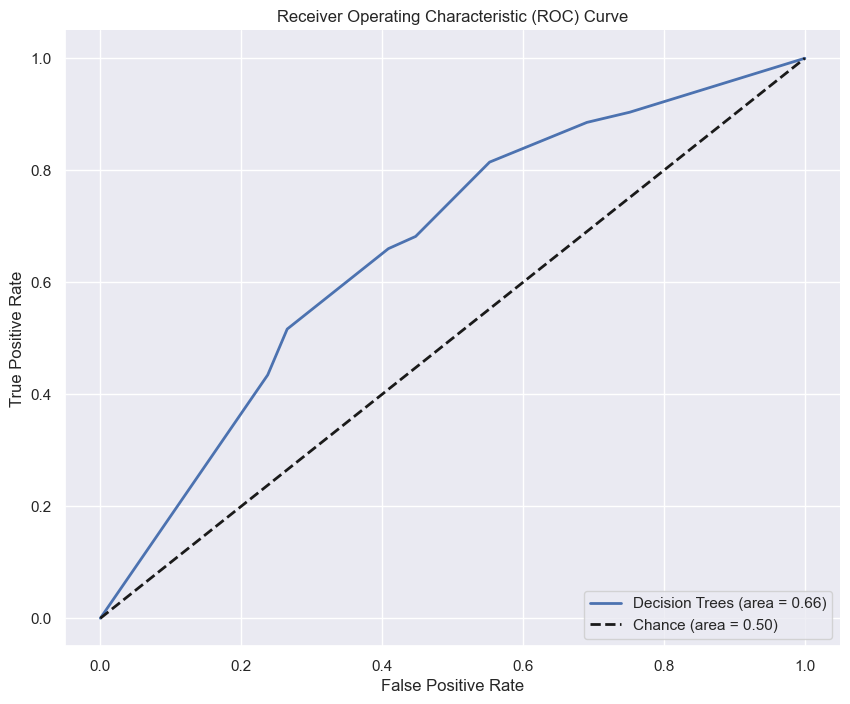

In [65]:
pipeline_dict_inf = {}
params_inf= {}
scores_inf = {}
for cls, hp, nm in zip(classifiers, hypers, names):
    if nm=="Decision Trees":
        hpers = params_dict[nm]
        pipeline = pipelines.MLPipeline(X_train, y_train, cls, hpers)
        pipeline.execute_feature_selection(corr_limit=0.6)
        pipeline.execute_preprocessing()
        pipeline.train_model(perform_grid_search=False)
        ppln = pipeline.build_pipeline()
        pipeline_dict_inf.update({nm:ppln})
        params_inf.update({nm:params})

        me = behave_metrics.ModelEvaluator(ppln,X_test)
        scores = me.evaluate()["y_test"]

        # Set optimal threshold as the average across Folds
        cnt = 0
        meas = 0
        for fold,val in thresholds[nm].items():
            cnt += 1
            meas += val
        average_threshold = meas/cnt if cnt!=0 else 0.5

        # Compute metrics on that threshold
        mr = behave_metrics.Metrics(scores, y_test)
        mr.compute_metrics(threshold=average_threshold)
        scores_dict = mr.get_scores() # the scores on the fold based on the best hyperparameters
        scores_inf.update({nm:scores_dict})

        # Perform Shap
        sp = shap_module.ShapAnalysis(X_val = X_test, pipeline_module = ppln, features=pipeline.selected_features) 
        shap_values,features = sp.perform_shap(), pipeline.selected_features

        os.mkdir(os.path.join("Materials", "Shap_Features"), exist_ok=True)
        path_shap = os.path.join("Materials", "Shap_Features")
        sp.plot_shap_values(model_name=nm, path= path_shap)

# display roc curves
roc = behave_metrics.ROCCurveEvaluator(pipeline_dict_inf,X_test=X_test, y_true=y_test)
roc.evaluate_models()
roc.plot_roc_curves(save_path=r"./Materials")



In [71]:
MetricsReport.external_summary(scores_inf, file = "test_results", conf_matrix_name="Test")

# ____ End of Code ____

In [ ]:

path_to_csv = r"Data\UC2_retrospective\ProCancer_UC2_N4_ADC_DL_PZ_radio.csv"
problematic = r"D:\dimza\EXPERIMENTS\ProstateCancerClinicalSignificance_UC2\UC2_prospective_and_retrospective\Borderline_cases_to_remove.csv"
jenn = r"Data\data_characteristics.csv"

exl = ["study_uid",
"number_of_series",
"pi_rads"]

rdc = RadiomicsClean(path_to_csv)
rdc.clean_borderlines(problematic)
rdc.drop_columns_from_df(excluded_columns = exl)
#rdc.create_target()
rdc.create_target_based_on_csv(target_csv=jenn)
rdc.keep_zone_location(zone="PZ")
#rdc.add_suffix("T2")
features = rdc.get_processed()
kalliatakis = X_test.iloc[:,0:2]
kalliatakis["y_pred"] = scores
kalliatakis["y_true"] = y_test
kalliatakis.drop(columns=["gradient_firstorder_10Percentile_T2","gradient_firstorder_90Percentile_T2"],inplace=True)
df1 = features.loc[kalliatakis.index,["provided_by", "manufacturer", "manufacturer_model_name"]]
kalliatakis = pd.concat([df1,kalliatakis], axis=1)
kalliatakis = kalliatakis[kalliatakis.provided_by.isin(["QUIRONSALUD","UNIPI", "HULAFE", "FPO", "IDIBGI"])]
kalliatakis["Country"] = "Spain"
kalliatakis["Country"][kalliatakis.provided_by.isin(["UNIPI", "FPO"])] = "Italy"
kalliatakis.to_csv("ClinicalSignificant_ProstateCancer.csv")
kalliatakis[kalliatakis.provided_by.isin(["QUIRONSALUD","UNIPI", "HULAFE", "FPO", "IDIBGI"])]

In [ ]:
csv_paths = [
    r"Data\UC2_prospespective\ProCancer_UC2_N4_T2_DL_PZ_radio.csv",
    r"Data\UC2_prospespective\ProCancer_UC2_N4_ADC_DL_PZ_radio.csv",
    r"Data\UC2_prospespective\ProCancer_UC2_N4_DWI_DL_PZ_radio.csv",
]

mpp = MultiParamProcessor(
    csv_paths = csv_paths,
    problematic = problematic
)
mpp.iteration(
    suffices=["T2", "ADC", "DWI"],
    columns_to_exclude= exl
)

dfs = mpp.get_dfs()
prospe = pd.concat([dfs[0], dfs[1], dfs[2]], axis = 1)
X_test = prospe.drop('Target', axis=1)  # Drop the 'Target' column for X_train
y_test = prospe['Target']

evaluator = ModelEvaluator(pipeline, X_test)

# Evaluate the model on validation and test datasets
evaluation_results = evaluator.evaluate()

In [ ]:
evaluation_results